<a href="https://colab.research.google.com/github/ahyz0569/STS/blob/yunok/doc/notebook/Detectron2_inference_200426.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install detectron2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# Or, to install it from a local clone:
!git clone https://github.com/facebookresearch/detectron2.git

Cloning into 'detectron2'...
remote: Enumerating objects: 4249, done.
remote: Total 4249 (delta 0), reused 0 (delta 0), pack-reused 4249
Receiving objects: 100% (4249/4249), 2.28 MiB | 10.97 MiB/s, done.
Resolving deltas: 100% (2988/2988), done.


In [2]:
cd detectron2

/content/detectron2


In [0]:
!python -m pip install -e .

In [0]:
# name 'unicode' is not defined error 해결
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# library import

In [0]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import os
import copy

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Prepare dataset

In [0]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset", {}, "/content/drive/My Drive/Final-project/detectron2/train/output_train.json", "/content/drive/My Drive/Final-project/detectron2/train/train_images")

In [8]:
ingre_metadata = MetadataCatalog.get("my_dataset")
ingre_metadata

Metadata(evaluator_type='coco', image_root='/content/drive/My Drive/Final-project/detectron2/train/train_images', json_file='/content/drive/My Drive/Final-project/detectron2/train/output_train.json', name='my_dataset')

In [9]:
from detectron2.data import DatasetCatalog
dataset_dicts = DatasetCatalog.get("my_dataset")

[04/26 07:39:15 d2.data.datasets.coco]: Loading /content/drive/My Drive/Final-project/detectron2/train/output_train.json takes 1.12 seconds.
WARNING [04/26 07:39:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/26 07:39:15 d2.data.datasets.coco]: Loaded 2944 images in COCO format from /content/drive/My Drive/Final-project/detectron2/train/output_train.json


In [0]:
dataset_dicts

# Config

In [0]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(
    # Same 
    '/content/detectron2/configs/COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml'
)
cfg.DATASETS.TRAIN = ("my_dataset",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
# cfg.SOLVER.BASE_LR = 0.02
# cfg.SOLVER.MAX_ITER = (
#     300
# )  # 300 iterations seems good enough, but you can certainly train longer
# cfg.SOLVER.STEPS = (70000, 90000)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)  # faster, and good enough for this toy dataset
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8

cfg.SOLVER.CHECKPOINT_PERIOD = 2000
cfg.OUTPUT_DIR = "/content/drive/My Drive/Final-project/detectron2"

# Prepare custom Dataloader

In [0]:
import copy
import logging
import numpy as np
import torch
from fvcore.common.file_io import PathManager
from PIL import Image

from detectron2.data import transforms as T
from detectron2.data import detection_utils as utils

"""
This file contains the default mapping that's applied to "dataset dicts".
"""

__all__ = ["DatasetMapper"]


class Custom_DatasetMapper:
    """
    A callable which takes a dataset dict in Detectron2 Dataset format,
    and map it into a format used by the model.
    This is the default callable to be used to map your dataset dict into training data.
    You may need to follow it to implement your own one for customized logic,
    such as a different way to read or transform images.
    See :doc:`/tutorials/data_loading` for details.
    The callable currently does the following:
    1. Read the image from "file_name"
    2. Applies cropping/geometric transforms to the image and annotations
    3. Prepare data and annotations to Tensor and :class:`Instances`
    """

    def __init__(self, cfg, is_train=True):
        if cfg.INPUT.CROP.ENABLED and is_train:
            self.crop_gen = T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE)
            logging.getLogger(__name__).info("CropGen used in training: " + str(self.crop_gen))
        else:
            self.crop_gen = None

        self.tfm_gens = utils.build_transform_gen(cfg, is_train)

        # fmt: off
        self.img_format     = cfg.INPUT.FORMAT
        self.mask_on        = cfg.MODEL.MASK_ON
        self.mask_format    = cfg.INPUT.MASK_FORMAT
        self.keypoint_on    = cfg.MODEL.KEYPOINT_ON
        self.load_proposals = cfg.MODEL.LOAD_PROPOSALS
        # fmt: on
        if self.keypoint_on and is_train:
            # Flip only makes sense in training
            self.keypoint_hflip_indices = utils.create_keypoint_hflip_indices(cfg.DATASETS.TRAIN)
        else:
            self.keypoint_hflip_indices = None

        if self.load_proposals:
            self.min_box_side_len = cfg.MODEL.PROPOSAL_GENERATOR.MIN_SIZE
            self.proposal_topk = (
                cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN
                if is_train
                else cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST
            )
        self.is_train = is_train

    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.
        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        image = utils.read_image(dataset_dict["file_name"], format="BGR")
        transform_list = [T.Resize((800, 800)),
                          T.ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'),
                        T.RandomFlip(prob=0.6, horizontal=True, vertical=False),
                        T.RandomFlip(prob=0.6, horizontal=False, vertical=True),
                        # T.RandomCrop(crop_type="relative_range", crop_size=(400, 400)),
                        T.RandomRotation(angle=[10.0, 160.0]),
                        # T.RandomContrast(0.7, 3.2),
                        T.RandomBrightness(0.9, 1.1)
                        ]
        image, transforms = T.apply_transform_gens(transform_list, image)

        # image aug check
        # flag = cv2.imwrite("/content/drive/My Drive/aa.jpg", image)
        # print(flag)
        
        dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
        
        annos = [
            utils.transform_instance_annotations(obj, transforms, image.shape[:2])
            for obj in dataset_dict.pop("annotations")
            if obj.get("iscrowd", 0) == 0
        ]
        instances = utils.annotations_to_instances(annos, image.shape[:2])
        dataset_dict["instances"] = utils.filter_empty_instances(instances)
        return dataset_dict

# Load Trainer

In [0]:
from detectron2.data import build_detection_train_loader
from detectron2.engine import DefaultTrainer

class Custom_Trainer(DefaultTrainer):

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=Custom_DatasetMapper(cfg, True))

In [13]:
# os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg)
trainer = Custom_Trainer(cfg)
trainer.resume_or_load(resume=True)
# trainer.train()

[04/26 07:39:35 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

# Inference & evaluation using the trained model

In [0]:
PRETRAIN_MODEL_PATH = '/content/drive/My Drive/Final-project/detectron2'

cfg.MODEL.WEIGHTS = os.path.join(PRETRAIN_MODEL_PATH, "model_0021999.pth")
# cfg.MODEL.WEIGHTS = os.path.join('/content/output/model_final.pth')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset_val2", )
predictor = DefaultPredictor(cfg)

# Prepare validation data

In [0]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_val2", {}, "/content/drive/My Drive/Final-project/detectron2/val/output_val.json", "/content/drive/My Drive/Final-project/detectron2/val/validation_images")

In [16]:
ingre_val_metadata = MetadataCatalog.get("my_dataset_val2")
from detectron2.data import DatasetCatalog
dataset_val_dicts = DatasetCatalog.get("my_dataset_val2")

WARNING [04/26 07:40:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/26 07:40:25 d2.data.datasets.coco]: Loaded 40 images in COCO format from /content/drive/My Drive/Final-project/detectron2/val/output_val.json


# Visualize predicted data

In [0]:
from detectron2.utils.visualizer import ColorMode

# for d in random.sample(dataset_val_dicts, 3):
for d in dataset_val_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=ingre_val_metadata, 
                   scale=0.8
    )
    print(outputs)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

outputs:  {'instances': Instances(num_instances=3, image_height=900, image_width=900, fields=[pred_boxes: Boxes(tensor([[176.6827,  94.9637, 442.2192, 206.6860],
        [164.4886, 187.6397, 257.4984, 278.7457],
        [  7.1819,   0.0000, 573.0621, 133.7627]], device='cuda:0')), scores: tensor([0.9556, 0.8937, 0.8519], device='cuda:0'), pred_classes: tensor([6, 1, 4], device='cuda:0')])}


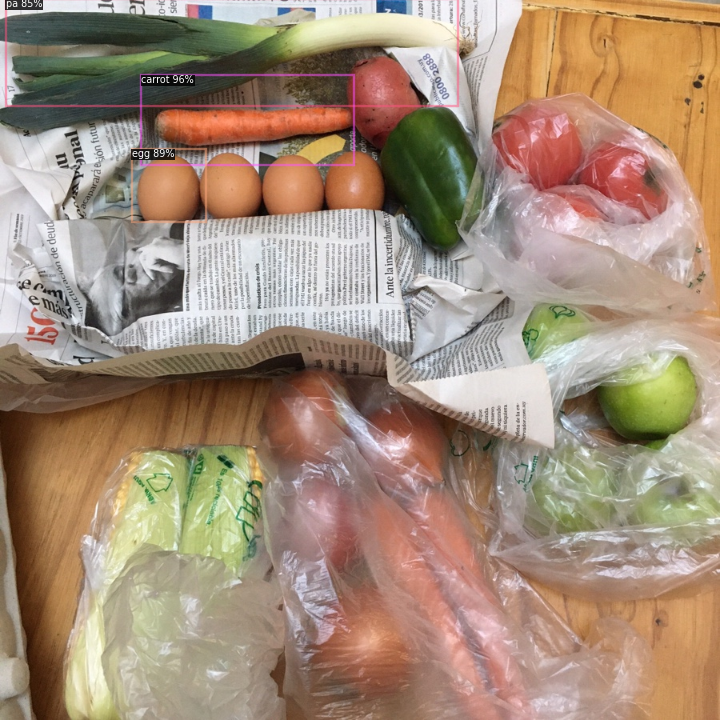

In [28]:
## 조금씩 찍어보기
## class명은 pred_classes / ex) pred_classes: tensor([2, 2]
from detectron2.utils.visualizer import ColorMode

for i in range(25, 26):
    im = cv2.imread(dataset_val_dicts[i]["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=ingre_val_metadata, 
                   scale=0.8
    )
    print("outputs: ", outputs)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

## evaluate its performance using AP metric implemented in COCO API

In [29]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val2", cfg, False, output_dir=PRETRAIN_MODEL_PATH)
val_loader = build_detection_test_loader(cfg, "my_dataset_val2")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [04/26 08:15:29 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/26 08:15:29 d2.data.datasets.coco]: Loaded 40 images in COCO format from /content/drive/My Drive/Final-project/detectron2/val/output_val.json
[04/26 08:15:29 d2.data.build]: Distribution of instances among all 8 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   chilli   | 24           |    egg     | 21           |  porkmeat  | 11           |
|   potato   | 10           |     pa     | 24           |   onion    | 30           |
|   carrot   | 16           |  cucumber  | 6            |            |              |
|   total    | 142          |            |              |            |              |
[04/26 08:15:29 d2.data.common]: Serializing 40 elements to byte tensors and concatenating them all ...
[04/26 08:15:2

OrderedDict([('bbox',
              {'AP': 23.482344214171118,
               'AP-carrot': 31.234223422342232,
               'AP-chilli': 13.96701443332811,
               'AP-cucumber': 18.734027248878732,
               'AP-egg': 18.36599475524751,
               'AP-onion': 14.320165384417367,
               'AP-pa': 23.839318079880773,
               'AP-porkmeat': 30.734744062641557,
               'AP-potato': 36.66326632663266,
               'AP50': 58.850231972310965,
               'AP75': 15.33593538430567,
               'APl': 23.749431122539484,
               'APm': 15.67821782178218,
               'APs': nan})])